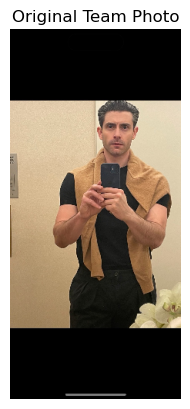

Image shape: (481, 222, 3)
R channel shape: (481, 222)
G channel shape: (481, 222)
B channel shape: (481, 222)

Running SVD compression for p = 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12658579722192093..1.058398244870288].


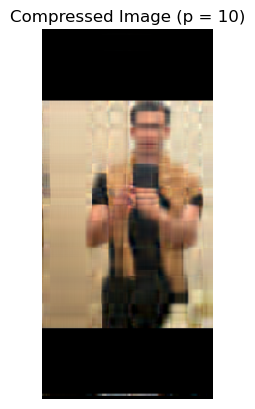


Running SVD compression for p = 25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1401202883411203..1.0562795630393662].


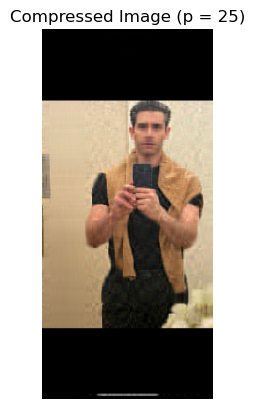


Running SVD compression for p = 50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06087821680068069..1.0565041627480773].


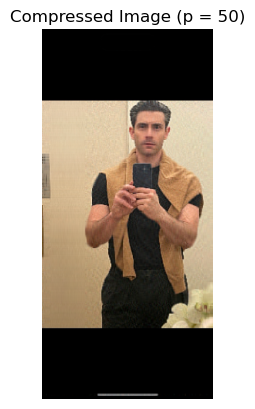


Running SVD compression for p = 100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04056289921785705..1.0355100940334347].


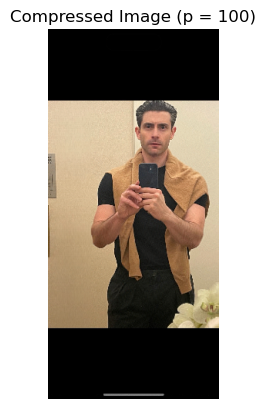


Summary of Results:
p = 10  | Compression Ratio: 0.0659 | Frobenius Error: 47.1837
p = 25  | Compression Ratio: 0.1648 | Frobenius Error: 30.2752
p = 50  | Compression Ratio: 0.3296 | Frobenius Error: 19.7116
p = 100 | Compression Ratio: 0.6593 | Frobenius Error: 9.7216


In [1]:
# ============================================================================
# Project 3 - SVD Image Compression
# Student: Gregory Schwartz
# Course: Numerical Methods
# Description: This script compresses a color image using a manually 
# Implemented Singular Value Decomposition (SVD) algorithm.
# ============================================================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread


# ============================================================================
# Load and Normalize Image
# ============================================================================
# Load image
img = imread('team_photo.JPG')

# Aggressively downsample
img = img[::3, ::3, :]  # SUPER small for fast compression

# Normalize if needed
if img.max() > 1.0:
    img = img / 255.0


# Display original image
plt.imshow(img)
plt.title("Original Team Photo")
plt.axis('off')
plt.show()

# Check image dimensions
print("Image shape:", img.shape)


# ============================================================================
# Function: power_iteration
# Purpose:  Compute the dominant eigenvalue and eigenvector of a symmetric matrix
# ============================================================================
def power_iteration(B, num_iters=1000, tol=1e-10):
    """
    Perform power iteration to find the dominant eigenvalue and eigenvector.

    Parameters:
    B : ndarray
        Symmetric matrix (e.g., A^T A)
    num_iters : int
        Maximum number of iterations
    tol : float
        Tolerance for convergence

    Returns:
    lambda_1 : float
        Dominant eigenvalue
    v : ndarray
        Corresponding normalized eigenvector
    """
    n = B.shape[1]
    v = np.random.rand(n)
    v = v / np.linalg.norm(v)

    for _ in range(num_iters):
        Bv = B @ v
        v_new = Bv / np.linalg.norm(Bv)
        if np.linalg.norm(v_new - v) < tol:
            break
        v = v_new

    lambda_1 = v.T @ B @ v
    return lambda_1, v


# ============================================================================
# Function: compute_manual_svd
# Purpose:  Compute top p singular values/vectors manually using power iteration
# ============================================================================
def compute_manual_svd(A, p, num_iters=1000, tol=1e-10):
    """
    Compute the top p singular values and vectors of matrix A.

    Parameters:
    A : ndarray
        Input matrix (e.g., color channel of image)
    p : int
        Number of components to keep
    num_iters : int
        Maximum iterations for power iteration
    tol : float
        Tolerance for convergence

    Returns:
    U : ndarray
        Left singular vectors (m x p)
    S : ndarray
        Diagonal matrix of singular values (p x p)
    Vt : ndarray
        Transposed right singular vectors (p x n)
    """
    m, n = A.shape
    ATA = A.T @ A
    V_list, U_list, S_list = [], [], []

    for _ in range(p):
        lambda_i, v_i = power_iteration(ATA, num_iters, tol)

        for v_prev in V_list:
            v_i -= np.dot(v_i, v_prev) * v_prev
        v_i /= np.linalg.norm(v_i)

        sigma_i = np.sqrt(lambda_i)
        u_i = (A @ v_i) / sigma_i

        V_list.append(v_i)
        U_list.append(u_i)
        S_list.append(sigma_i)

        ATA -= sigma_i**2 * np.outer(v_i, v_i)

    U = np.column_stack(U_list)
    V = np.column_stack(V_list)
    S = np.diag(S_list)
    return U, S, V.T


# ============================================================================
# Function: reconstruct_image
# Purpose:  Rebuild matrix from truncated SVD
# ============================================================================
def reconstruct_image(U, S, Vt):
    """
    Reconstruct matrix using U, S, Vt.

    Returns:
    A_p : ndarray
        Approximated matrix
    """
    return U @ S @ Vt


# ============================================================================
# Split the image into R, G, B channels
# ============================================================================
R = img[:, :, 0]
G = img[:, :, 1]
B = img[:, :, 2]

print("R channel shape:", R.shape)
print("G channel shape:", G.shape)
print("B channel shape:", B.shape)


# ============================================================================
# Compress and Reconstruct Image for Different p Values
# ============================================================================
p_values = [10, 25, 50, 100]
results = []

for p in p_values:
    print(f"\nRunning SVD compression for p = {p}")

    U_R, S_R, Vt_R = compute_manual_svd(R, p)
    U_G, S_G, Vt_G = compute_manual_svd(G, p)
    U_B, S_B, Vt_B = compute_manual_svd(B, p)

    R_p = reconstruct_image(U_R, S_R, Vt_R)
    G_p = reconstruct_image(U_G, S_G, Vt_G)
    B_p = reconstruct_image(U_B, S_B, Vt_B)

    img_p = np.stack([R_p, G_p, B_p], axis=2)

    # Display the compressed image
    plt.imshow(img_p)
    plt.title(f"Compressed Image (p = {p})")
    plt.axis('off')
    plt.show()

    # Compute compression ratio
    m, n = R.shape
    original_size = m * n * 3
    compressed_size = 3 * p * (m + n + 1)
    compression_ratio = compressed_size / original_size

    # Compute Frobenius norm error
    error = (
        np.linalg.norm(R - R_p, 'fro') +
        np.linalg.norm(G - G_p, 'fro') +
        np.linalg.norm(B - B_p, 'fro')
    )

    results.append((p, compression_ratio, error))


# ============================================================================
# Summary Output: Compression Ratios and Errors
# ============================================================================
print("\nSummary of Results:")
for p, ratio, err in results:
    print(f"p = {p:<3} | Compression Ratio: {ratio:.4f} | Frobenius Error: {err:.4f}")
